# Environment configuration


GPU's to use

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Directory where celeb_a data will be cached (because gdrive doesn't respond frequently)

In [2]:
data_dir="/notebooks/datasets"
out_dir = "/notebooks/dfc_vae/models"
log_dir_base = '/notebooks/logs/dfc_vae'


# Imports

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, Sequential, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda,Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
from tqdm import tqdm
import io


# Prepare data

In [4]:

data, info = tfds.load("celeb_a", with_info=True, data_dir=data_dir)

In [5]:
train_data, val_data, test_data = data['train'], data['validation'], data['test']

image_size = (128, 128)
image_shape = (128,128,3)
image_shape_batch = (None, 128,128,3)

#image_size = (64, 64)
#image_shape = (64, 64, 3)
#image_shape_batch = (None, 64, 64, 3)



def crop_resize_normalize(item):
    img = item['image']
    landmarks = item['landmarks']

    #image_cropped = img[45:-45, 25:-25]
    image_cropped = img[35:-35, 15:-15]
    image_cropped = tf.cast(image_cropped, tf.float32) / 255.0
    image_cropped = tf.image.resize(image_cropped, image_size)
    
    item["image"] = image_cropped 
    return item

In [6]:

batch_size = 64 

def preprocess(image):
    image = image['image']
    return image

def preprocess_test(image):
    return image['image']



steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['validation'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).batch(batch_size).prefetch(1)


# Network architecture

In [7]:
class Encoder(Layer):
    def __init__(self, input_dim, latent_dim=100, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.ccn = tf.keras.Sequential([
                Input(shape=input_dim),
                Conv2D(32, 4, strides=(2, 2)),
                BatchNormalization(),
                LeakyReLU(),

                Conv2D(64, 4, strides=(2, 2)),
                BatchNormalization(),
                LeakyReLU(),

                Conv2D(128, 4, strides=(2, 2)),
                BatchNormalization(),
                LeakyReLU(),

                Conv2D(256, 4, strides=(2, 2)),
                BatchNormalization(),
                LeakyReLU(),

                Conv2D(512, 4, strides=(2, 2)), # remove this for 64
                BatchNormalization(),#
                LeakyReLU(),#

                GlobalAveragePooling2D()

            ])
        self.z_mean_fc = Dense(latent_dim, name='mean')
        self.z_log_var_fc = Dense(latent_dim)

    def call(self, x_input):
        z = self.ccn(x_input)
        mu = self.z_mean_fc(z)
        log_var = self.z_log_var_fc(z)
        return mu, log_var

class Decoder(Layer):
    def __init__(self, latent_dim, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.latent_dim = latent_dim

        self.cnn = tf.keras.Sequential([
          Input(shape=(latent_dim,)),
          Dense(4096),
          Reshape((4, 4, 256)),

          UpSampling2D((2, 2), interpolation='nearest'),
          Conv2D(128, 3, strides=1, padding='same'),
          BatchNormalization(),
          LeakyReLU(),

          UpSampling2D((2, 2), interpolation='nearest'),
          Conv2D(64, 3, strides=1, padding='same'),
          BatchNormalization(),
          LeakyReLU(),

          UpSampling2D((2, 2), interpolation='nearest'),
          Conv2D(32, 3, strides=1, padding='same'),
          BatchNormalization(),
          LeakyReLU(),

          UpSampling2D((2, 2), interpolation='nearest'),# remove this for 64
          Conv2D(16, 3, strides=1, padding='same'),#
          BatchNormalization(),#
          LeakyReLU(),#

          UpSampling2D((2, 2), interpolation='nearest'),
          Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')])
      
    def call(self, z):
          return self.cnn(z)
  


class VAE(Model):
    """Variational auto encoder"""
    def __init__(self, input_dim, latent_dim, learning_rate, name="autoencoder", **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        
        
    def sample(self, mean, log_var):
          eps_shape = (K.shape(mean)[0], self.latent_dim)
          epsilon = K.random_normal(shape=eps_shape)
          z = epsilon*K.exp(log_var/2) + mean
          return z
          
        
    def call(self, x_input):
        mean, log_var = self.encoder(x_input)

        z_sample = self.sample(mean, log_var)

        x_recons_logits = self.decoder(z_sample)

        return x_recons_logits, mean, log_var,z_sample



# Loss functions


In [8]:
class PlainVaeLoss():
    """Palin VAE loss for test purposes
    from https://www.tensorflow.org/tutorials/generative/cvae
    """
    def __init__(self, input_dim, latent_dim, name="plain", **kwargs):
        self.input_dim= input_dim
        self.latent_dim = latent_dim

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def calculate_loss(self, x, z_decoded, z_mean, z_log_var, z):
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_decoded, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, z_mean, z_log_var)
        total =  -tf.reduce_mean(logpx_z + logpz - logqz_x)
        
        def assert_non_nan(a, name):# todo remove
            a = a.numpy()
            if np.isnan(a).any():
                print(f"Is Nan {name} {a}")
        
        assert_non_nan(x, "x")
        assert_non_nan(z_decoded, "z_decoded")
        assert_non_nan(z_mean, "z_mean")
        assert_non_nan(z_log_var, "z_log_var")
        assert_non_nan(z, "z")

        assert_non_nan(cross_ent, "cross_ent")
        assert_non_nan(logpx_z, "logpx_z")
        assert_non_nan(logpz, "logpz")
        assert_non_nan(logqz_x, "logqz_x")
        assert_non_nan(total, "total")

        return total

class DfcLoss():
    """
    DFC loss
    https://arxiv.org/pdf/1610.00291.pdf
    """
    def __init__(self, vgg, input_dim, latent_dim, beta=0.5, **kwargs):
        self.vgg = vgg
        self.input_dim= input_dim
        self.latent_dim = latent_dim
        self.vgg_layers_to_use = ['block1_conv1', 'block2_conv1', 'block3_conv1']#like in paper vae123
        self.vgg_layer_weights =  [1., 1., 1.] # like in paper
        vgg_names_dict = dict([ (l.name,l) for l in vgg.layers])
        out_layers = [vgg_names_dict[name] for name in self.vgg_layers_to_use]
        self.beta = beta
        self.vgg_reduced = Model(inputs = vgg.layers[0].input, outputs=[l.output for l in out_layers])


    def perceptual_loss(self, x, z_decoded):
        h1_list = self.vgg_reduced(x)
        h2_list = self.vgg_reduced(z_decoded)
        rc_loss = 0.0

        for h1, h2, weight in zip(h1_list, h2_list, self.vgg_layer_weights):
            rc_loss = rc_loss + weight * K.mean(K.square(h1 - h2))

        return rc_loss

    def kl_loss(self, z_mean, z_log_var):
        kl = K.mean(-0.5 * K.sum(1 + z_log_var \
                        - K.square(z_mean) \
                        - K.exp(z_log_var), axis=-1))

        return kl


    def calculate_loss(self, x, z_decoded, z_mean, z_log_var, z):
        '''Total loss for the DFC VAE'''
        return self.beta * self.perceptual_loss(x, z_decoded) + self.kl_loss(z_mean, z_log_var)
    
        
    def call(self, input):
        return self.calculate_loss(input[0], input[1], input[2], input[3])



# Train procedure

In [9]:
test_size = 10000
latent_dim=100
lr = 0.0005
epochs = 5

In [26]:
logdir = os.path.join(log_dir_base,  datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = tf.summary.create_file_writer(logdir)


@tf.function
def train_step(x_true, dfc_vae:VAE, dfc_loss, optimizer):
    with tf.GradientTape() as tape:
        x_recons_logits, mean, log_var, z_sample = dfc_vae(x_true)
        loss = tf.math.reduce_sum(dfc_loss.calculate_loss(x=x_true, z_decoded=x_recons_logits, z_mean=mean, z_log_var=log_var, z=z_sample))

    
    gradients = tape.gradient(loss, dfc_vae.trainable_variables)
  
    optimizer.apply_gradients(zip(gradients, dfc_vae.trainable_variables))
    return loss


@tf.function
def decode(vae_model, n):
    return vae_model.decoder(tf.random.normal(shape=[n,latent_dim]))

@tf.function
def reconstruct(vae_model, x):
    return vae_model(x)

def generate_images(vae_model):

    n = 10
    resp = decode(vae_model, n)
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(resp[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

class TensorboarHelper:
    def _plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def _image_grid(images_to_plot):
        """Return a 3x3 grid of the MNIST images as a matplotlib figure."""
        # Create a figure to contain the plot.
        figure = plt.figure(figsize=(10,10))
        for i in range(9):
            #plt.subplot(3, 3, i + 1, title=class_names[train_labels[i]])
            plt.subplot(3, 3, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images_to_plot[i])

        return figure

    def plot_images(writer, images_to_plot, step, name):
        figure = TensorboarHelper._image_grid(images_to_plot)
        with writer.as_default():
            tf.summary.image(name=name, data=TensorboarHelper._plot_to_image(figure), step=step)


def log_images(vae_model, step):

    n = 10
    resp = decode(vae_model, n)
    #tf.summary.image("Generated", resp, step=step, max_outputs=9)
    TensorboarHelper.plot_images(writer=writer, images_to_plot=resp, step=step, name="Generated")
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(resp[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

images_to_reconstruct = next(iter(val_ds))
def log_test_reconstruction(vae_model, step):

    with writer.as_default(step):
        n = 10
        resp, mean, log_var,z_sample = reconstruct(vae_model, images_to_reconstruct)
        
        #tf.summary.image("Reconstructed", resp, step=step, max_outputs=9)
        
        TensorboarHelper.plot_images(writer=writer, images_to_plot=resp, step=step, name="Reconstructed")
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(images_to_reconstruct[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            # display reconstruction
            ax = plt.subplot(2, n, i + n + 1)
            plt.imshow(resp[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()



    

# Run train

  0%|          | 0/2543 [00:00<?, ?it/s]

Loss 1017.8892211914062
Generation


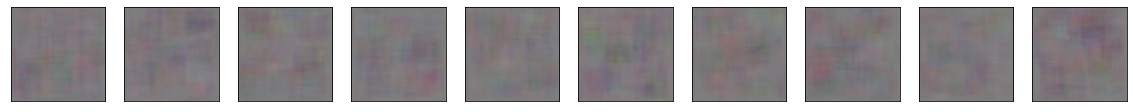

Reconstruction


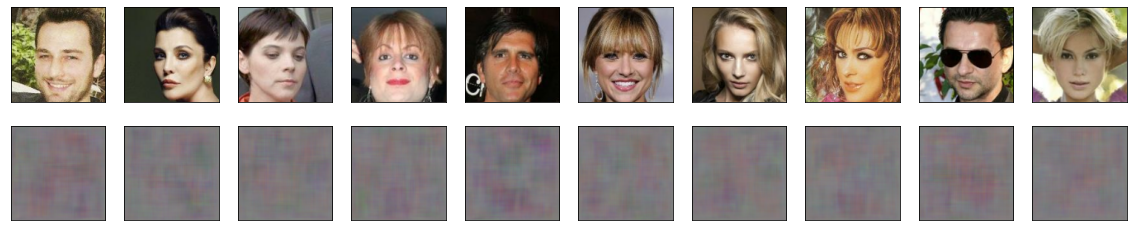

 20%|█▉        | 500/2543 [02:19<07:55,  4.30it/s]

Loss 795.3839721679688
Generation


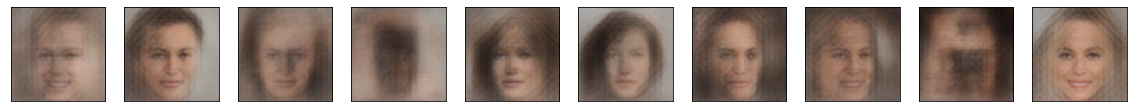

Reconstruction


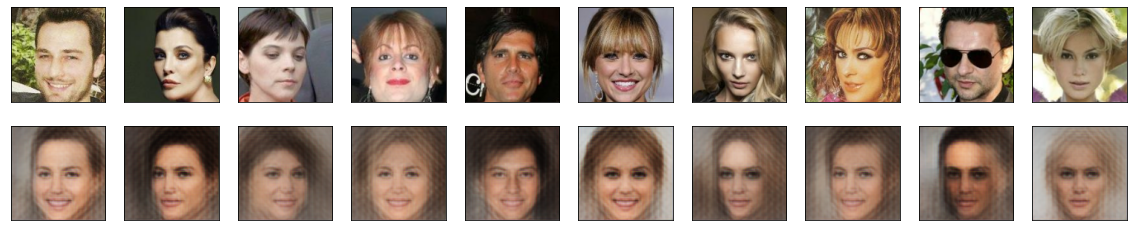

 39%|███▉      | 1000/2543 [04:18<05:59,  4.30it/s]

Loss 750.58740234375
Generation


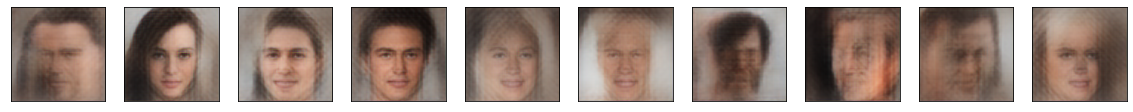

Reconstruction


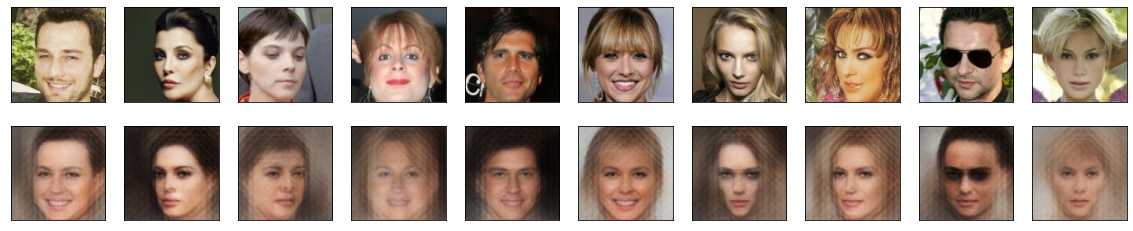

 59%|█████▉    | 1500/2543 [06:21<04:01,  4.32it/s]

Loss 725.193603515625
Generation


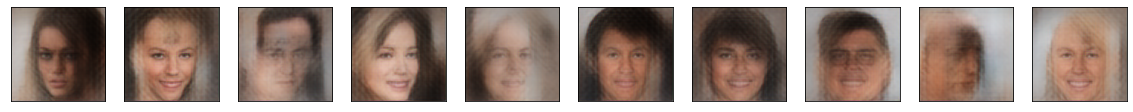

Reconstruction


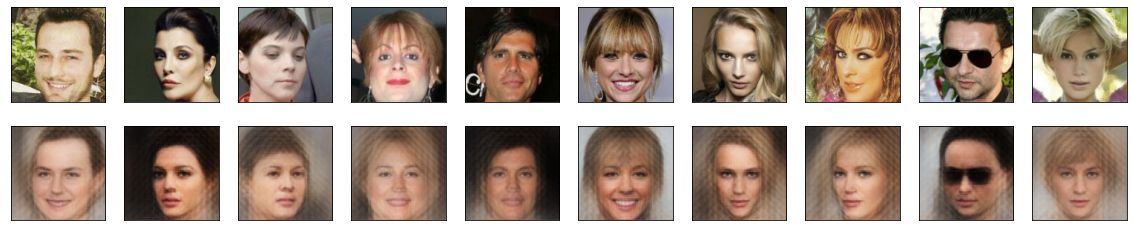

 79%|███████▊  | 2000/2543 [08:20<02:07,  4.27it/s]

Loss 707.4951171875
Generation


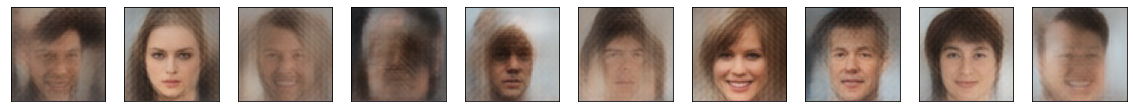

Reconstruction


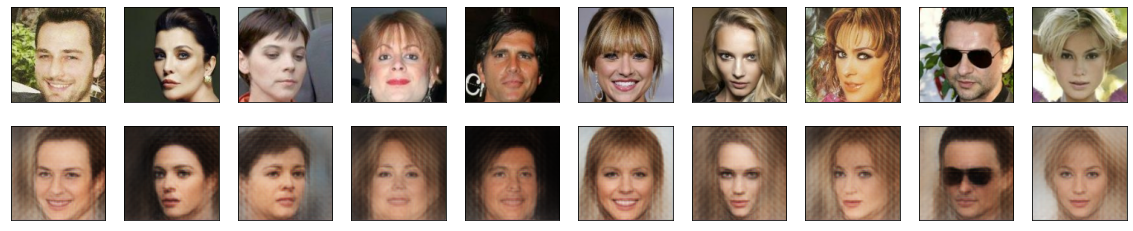

 98%|█████████▊| 2500/2543 [10:19<00:10,  4.29it/s]

Loss 694.5443115234375
Generation


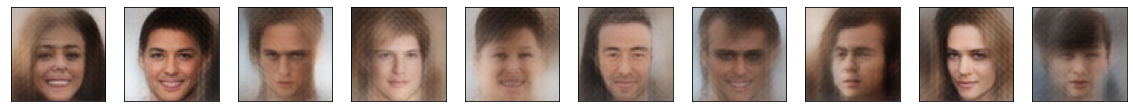

Reconstruction


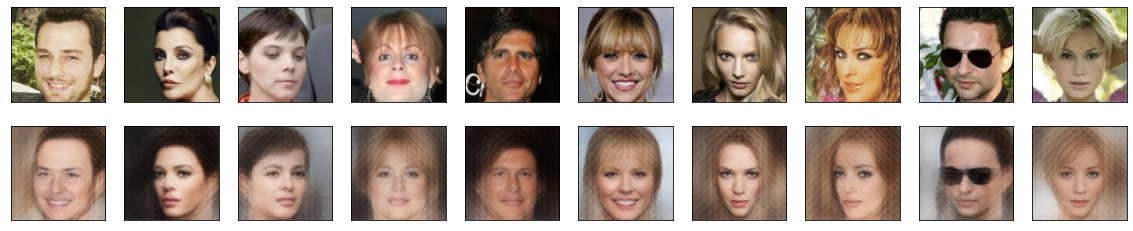

2544it [10:32,  4.02it/s]


Save vae


In [30]:

vgg = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
loss_obj = DfcLoss(vgg=vgg, input_dim=image_shape, latent_dim=latent_dim , beta=128)
model_prefix = "dfc_vae"
vae = VAE(input_dim=image_shape, latent_dim=latent_dim,learning_rate=lr)
vae.compile()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=steps_per_epoch,
    decay_rate=0.5,
    staircase=True)

opt = tf.optimizers.Adam(learning_rate=lr_schedule)


tf.config.run_functions_eagerly(True)


for epoch in range(epochs):
    loss_metric = tf.keras.metrics.Mean()

    start_time = time.time()
    step = 0
    for train_x in tqdm(train_ds, total=steps_per_epoch):
        
        loss = train_step(train_x, vae, loss_obj, opt)
        loss_metric(loss)

        total_step = epoch*steps_per_epoch + step
        with writer.as_default(total_step):
            tf.summary.scalar("loss", loss)
        
        if step % 500 == 0: 
            print(f"Loss {loss_metric.result()}")
            print("Generation")
            log_images(vae, step=total_step)
            print("Reconstruction")
            log_test_reconstruction(vae, step=total_step)
        step = step + 1

    print("Save vae")
    tf.keras.models.save_model(vae, os.path.join(out_dir, f"{model_prefix}_epoch={epoch}.model"), save_format="tf")
        
    end_time = time.time()
    elbo = -loss_metric.result()
    print('Epoch: {}, Train set ELBO: {}, time elapse for current epoch: {}'.format(
            epoch, elbo, end_time - start_time))
    generate_images(vae)

# Test model


In [31]:
def generate_from_checkpoint(checkpoint:str):
    vae = tf.keras.models.load_model(os.path.join(out_dir, checkpoint))
    generate_images(vae)
    #log_images(vae, 1)
    del vae

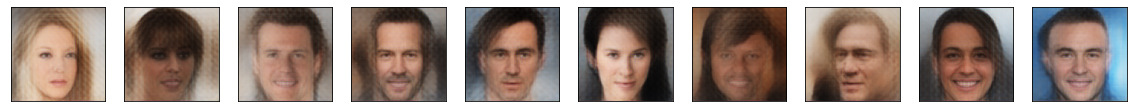

In [32]:
checkpoint = f"{model_prefix}_epoch={epochs-1}.model"
generate_from_checkpoint(checkpoint)

# Save z-vectors 

In [ ]:
checkpoint = f"{model_prefix}_epoch={epochs-1}.model"
#checkpoint = "dfc_vae_epoch=4.model"
vae_model = tf.keras.models.load_model(os.path.join(out_dir, checkpoint))
attr_data = tfds.load("celeb_a", split=tfds.Split.TRAIN, data_dir=data_dir)

In [47]:
@tf.function
def encode(vae_model, batch):
    return vae_model.encoder(batch)
    
def get_z_vectors(vae_model: VAE, dataset):
    res = []
    batched_ds = dataset.map(crop_resize_normalize).batch(batch_size=64)
    for batch in tqdm(batched_ds):
        mean_batch, log_var_batch = encode(vae_model, batch["image"]) 
        res.append({"z_mean": mean_batch.numpy(), "z_log_var": log_var_batch.numpy() , "attributes": dict([(k, v.numpy()) for (k,v) in batch["attributes"].items()])})
    
    return res

In [83]:
z_vectors = get_z_vectors(vae_model, attr_data)

100%|██████████| 2544/2544 [00:16<00:00, 157.31it/s]


In [147]:
import pickle 
with open(f"{model_prefix}_epoch={epochs-1}_z_vectors.pt", "wb") as f:
    pickle.dump(z_vectors, f)
    